In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk
import scipy 
import igraph
import ts2vg # Time series to visibility graphs
import scipy.spatial.distance as distance
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import os 
from scipy.stats import t 
from osgeo import ogr
import sys

#### Tasks para Mutual Information:
    1. Gerar redes contendo o mesmo número de arestas da rede Pearson
    2. Gerar redes com limiar baseado no maior diâmetro (e backbone associado)
    3. Gerar redes com limiar baseado nas maiores (1%) correlações (e backbone associado)
    4. Verificar as características de todas as redes e realizar a geração do shapefile

#### Funções e Classes

In [10]:
class threshold():
    # Remover arestas com peso abaixo de um dado threshold (valor real)
    # entrada: g, flow_threshold
    # retorno: g              
    def remove_edges(g, flow_threshold):
        del_edges = []
        for e in g.es():
            if e['weight'] < flow_threshold:
                del_edges.append(e)
        g.delete_edges(del_edges)
        return g

    # Função que varia o threshold e chama a função acima 
    # remover as arestas abaixo do threshold e em seguida verifica o diâmetro
    # Entrada: g
    # Retorno: threshold (valor real) associado ao maior diâmetro da rede
    def max_diameter_threshold(g):
        max_threshold = max(g.es['weight'])
        max_diameter = 0
        for t in np.arange(0.1, max_threshold, 0.01):
            #print(threshold)
            ng = g.copy()
            ng = threshold.remove_edges(ng, t)
            #print(ng)
            diameter = ng.diameter(directed=False)
            #print(diameter)
            if diameter > max_diameter:
                max_diameter = diameter
                threshold_max_diameter = t
        return threshold_max_diameter

def geographical_distance_3d(adj,pos,alt):
    """
    Parameters:
    -----------
        adj - pares de pontos que correspondem a um ponto (série temporal) disposta no espaço geográfico da 
        bacia do rio Tamanduateí.
        pos - índice (d,j) de cada ponto na matriz que representa o espaço geográfico.
        alt - representa os dados de altimetria para cada ponto no espaço
        
    Returns:
    --------

    """
    geo_3d_dist = {}
    for i in adj: # i é o par formado pelos grafos 'a' e 'b'
        a = pos[i[0]] # busca as coordenadas (i,j) do grafo 'a' no vetor que guarda a posição das séries na matriz
        b = pos[i[1]] # busca as coordenadas (i,j) do grafo 'b' no vetor que guarda a posição das séries na matriz
        dist = np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
        dist3d = np.sqrt(dist**2 + (alt[i[0]]-alt[i[1]])**2)
        geo_3d_dist[i] = dist3d
        
    return(geo_3d_dist)

def geographical_distance(adj,pos):
    """
    Parameters:
    -----------
        adj - pares de pontos que correspondem a um ponto (série temporal) disposta no espaço geográfico da 
        bacia do rio Tamanduateí.
        pos - índice (d,j) de cada ponto na matriz que representa o espaço geográfico.
        
    Returns:
    --------
        A distância euclidiana entre os pontos distribuídos na região analisada.
    """
    geo_dist = {}
    for i in adj: # i é o par formado pelos grafos 'a' e 'b'
        a = pos[i[0]] # busca as coordenadas (i,j) do grafo 'a' no vetor que guarda a posição das séries na matriz
        b = pos[i[1]] # busca as coordenadas (i,j) do grafo 'b' no vetor que guarda a posição das séries na matriz
        dist = np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
        geo_dist[i] = dist
    return(geo_dist)

class reading():
    
    def files_and_validation():
        """
        Returns:
        --------
            Realiza a leitura dos arquivos contendo as matrizes de dados. Os dados inválidos das matrizes (-99) são
            removidos, gerando vetores com apenas os valores válidos.
            data ==> Vetor contendo apenas os valores válidos das matrizes
            pos ==> Vetor contendo a posição que os valores válidos ocupam na matriz de dados original
        """
        files_list = os.listdir('data-01-original');
        files_list.sort();
        data = [];
        for i in range(len(files_list)):
            m = np.genfromtxt('data-01-original/'+str(files_list[i]));
            validated = [];
            pos = [];
            for row in range(len(m[:,0])):
                for column in range(len(m[0,:])):
                    if (m[row][column] != -99):
                        validated.append(m[row,column]);
                        pos.append([row,column]);
            data.append(validated);
                    
        return(data,pos);

    def timeSeriesGeneration(validated_data):
        """
        Parameters:
        -----------
            Arrays unidimensionais contendo os valores estimados das previsões
        Returns:
        --------
            Série temporal associada a cada ponto válido (diferente de -99).
            A série temporal 0 será composta por todos os valores na posição 0 dos 4464 arrays, e assim
            em diante. O resultado são 587 séries temporais de tamanho 4464.
        """
        time_series = {};
        for i in range(len(validated_data[0])):
            s = np.empty((0,0));
            for j in range(len(validated_data)):
                s = np.append(s,validated_data[j][i]);
            time_series[i] = s;
        
        for t in range(len(time_series)):
            for k in range(len(time_series[0])):
                if (time_series[t][k] < 20):
                    time_series[t][k] = 0;
                
        return(time_series);
        

def mutual_information(ts):
    """
    Parameters:
    -----------
        ts - Conjunto de séries temporais lidas inicialmente. Cada série é comparada com todas as outras usando 
        mutual information. 
    Returns:
    --------
        mi_dict - Retorna um dicionário. As chaves correspondem às séries e os valores são a distância geográfica e
        a informação mútua
    """    
    mi_dict = {};
    ctrl = 1;
    for i in range(len(ts)):
        for j in range(ctrl,len(ts)):
            mi = sk.normalized_mutual_info_score(ts[i], ts[j], average_method='arithmetic');
            mi_dict[i,j] = [geo_dist[i,j],mi];
        ctrl += 1;
    return(mi_dict);

def g_graph(data):
    """
    Parameters:
    -----------
        data - Dicionário contendo os pares de séries temporais e seus respectivos pesos. Cada par presente no 
        dicionário representa uma conexão entre dois nós da rede.
    Returns:
    --------
        plt - Contém o plot do grafo
        gr - Variável contendo o objeto grafo do tipo igraph 
    """
    gr = igraph.Graph();
    gr.add_vertices(587); # Valor estático. O número de nós na rede geográfica é constante.
    gr.add_edges((list(data.keys())));
    gr.vs['x'] = [position[i][1] for i in range(587)];
    gr.vs['y'] = [position[j][0] for j in range(587)];
    gr.es['weight'] = [i[1] for i in list(data.values())];
    lyt = [];
    for i in range(587):
        lyt.append( (gr.vs[i]['x'],gr.vs[i]['y']) );
    visual_style = {};
    visual_style['layout'] = lyt;
    visual_style['bbox'] = (500,500);
    visual_style['margin'] = 20;
    visual_style['vertex_size'] = 5;
    visual_style['edge_width'] = 1.5;
    plt = igraph.plot(gr,**visual_style);
    #igraph.plot(gr,'basin-region-js-0dot358.png',**visual_style);
    return(plt,gr); #plot object and the graph itself

#def strength_vertex(g,i):
#    strength_list = g.strength(weights=g.es['weight']) # lista com o strength de todos os nós da rede
#    return(strength_list[i])

def backbone(g,alpha):
    # pij = (1 - (wij/si))**(ki - 1), onde:
    # w --> weight
    # s --> strength
    # k --> degree
    p={}
    adj = g.get_adjacency()
    n_nodes = g.vcount()
    strength_vertex = g.strength(weights=g.es['weight'])
    for i in range(n_nodes):
        for j in range(n_nodes):
            if (adj[i,j] == 1): # verificando se há conexão entre o par i,j
                w = g.es[g.get_eid(i,j)]['weight']
                s = strength_vertex[i] # calcula o strength de toda a rede e retorna apenas para o nó desejado
                k = g.vs[i].degree()
                pij = (1 - (w/s))**(k-1)
                if (pij < alpha): # aplicando a relação com o alpha
                    p[i,j] = [pij,w]

    # Pegando os pares simétricos e atribuindo -99 ao par com maior valor de probabilidade
    for i in p:
        if ((i[0],i[1]) and (i[1],i[0])) in p.keys():
            if p[i[0],i[1]][0] <= p[i[1],i[0]][0]:
                p[i[1],i[0]][0] = -99
            else:
                p[i[0],i[1]][0] = -99

    # Criando dicionário com os pares válidos
    bb = {}
    for i in p:
        if not (p[i][0] == -99):
            bb[i] = p[i]

    return(bb)


class metrics():
    def __init__(self,graph):
        self.graph = graph
    
    def heterogeneity(self):
        degree = self.graph.degree()
        power_degree = [] # degree sequence 
        for i in degree:
            power_degree.append(i**2)
            hp = ( (sum(power_degree)/len(power_degree))/((sum(degree)/len(degree))**2) )
        return(hp)
    
    def components(self):
        n_comp = len(self.graph.components())
        n_singletons = len([i for i in self.graph.components().sizes() if i == 1])
        biggest_comp = max(self.graph.components().sizes())
        avg_comp = sum(self.graph.components().sizes())/n_comp # Soma do tamanho de todos os componentes / n comp
        dict_comp = {
            'n_comp': n_comp,
            'n_singletons': n_singletons,
            'biggest_comp': biggest_comp,
            'avg_comp': avg_comp
        }
        return(dict_comp)
    
    def avg_shortest_path(self): # All graph (connected nodes) - Unweighted
        avg_shortest_paths = {}
        shrtst_paths_inf = self.graph.shortest_paths()
        sp = [];
        for source in range(len(shrtst_paths_inf)):
            v = [];
            for target in range(len(shrtst_paths_inf[source])):
                if ((shrtst_paths_inf[source][target] != float('inf')) and (shrtst_paths_inf[source][target] != 0 and (source != target)) and (source != target)):
                    v.append(shrtst_paths_inf[source][target]);
            if (len(v) == 0):
                avg = 0;
            else:
                avg = sum(v)/len(v);
            sp.append(avg);

        avg = sum([i for i in sp if i != 0])/len([i for i in sp if i != 0])

        return(avg)
    
    def all_metrics(self):
        return(self.heterogeneity(),self.components(),self.avg_shortest_path(),self.graph.transitivity_undirected(),self.graph.diameter())
    
def shortest_paths(g, weight):
    """
    Parameters:
    -----------
        Graph object (igraph)
        weight 
    Returns:
    --------
        The shortest path between all connected nodes
    """
    s_paths = {};
    if not (weight):
        ctrl = 1;
        for i in range(g.vcount()):
            for j in range(ctrl,g.vcount()):
                path = g.shortest_paths(source=g.vs[i],target=g.vs[j])
                if (path[0][0] != float('inf')):
                    s_paths[i,j] = path[0][0];
            ctrl+=1
    else:
        ctrl = 1;
        for i in range(g.vcount()):
            for j in range(ctrl,g.vcount()):
                path = g.shortest_paths(source=g.vs[i],target=g.vs[j],weights=g.es['weight']) 
                if (path[0][0] != float('inf')):
                    s_paths[i,j] = path[0][0];
            ctrl+=1
        
    return(s_paths);

def plot_geo_top(data):
    """
    Parameters:
    -----------
        data - Dicionário contendo os pares de séries temporais e seus respectivos pesos. Cada par presente no 
        dicionário representa uma conexão entre dois nós da rede.
        
        Retorna um gráfico contendo a distância geográfica no eixo das abscissas e distância topológica no eixo das
        ordenadas, bem como as informações do modelo de regressão linear usado para mostrar a relação entre os eixos.
    """
    geo = np.array([i[1] for i in list(data.values())]);
    top = np.array([i[0] for i in list(data.values())]);
    geo = geo.reshape(-1,1);
    top = top.reshape(-1,1);
    # Linear Regression
    reg = LinearRegression();
    reg.fit(geo,top);
    score = round(reg.score(geo,top),4);
    a = round(reg.coef_[0][0],4);
    b = reg.intercept_;
    top_new = (a*geo) + b;
    # Plot
    plt.figure(figsize=(15,10));
    plt.scatter(geo,top,s=20,alpha=0.08);
    plt.plot(geo,top_new,color='red');
    plt.grid(True);
    plt.xlabel('Geographical Distance [km]',fontsize='xx-large');
    plt.ylabel('Topological Distance [Number of edges]',fontsize='xx-large');
    plt.text((max(geo)*0.5)[0], (min(top))[0], 'R² = '+str(score), horizontalalignment='center',verticalalignment='center',fontsize='xx-large');
    plt.text((max(geo)*0.75)[0], (min(top))[0], 'Slope = '+str(a), horizontalalignment='center',verticalalignment='center',fontsize='xx-large');
    
def teste_hipotese(x,y,alfa):
    
    
    '''T-test hypothesis testing for regression. Returns 1 if null Hypthotesis can be rejected 
    (considering the chosen alfa ) and 0 if it can't.
    
    Parameters:
    -------------------------------------------
    x and y: Variables 
    alfa: Desired statistical significance.'''
    
    n = len(x)
    xmed = np.sum(x)/n;
    ymed = np.sum(y)/n;
    i = 0
    ttable = 1.960
    reject=0       
    reject0=0     
    Sxy = 0
    Sxx = 0 
    Syy = 0
    for i in range(n):
        Sxy = Sxy + ((x[i]-xmed)*(y[i]-ymed))
        Sxx = Sxx + np.power(x[i]-xmed, 2)

    b1 = Sxy/Sxx
    b0 = ymed-b1*xmed

    for i in range(n):
        Syy = Syy + np.power(y[i]-ymed, 2)

    R2 = np.power(Sxy,2)/(Sxx*Syy)
    R2a = 1 - ((n-1)/(n-2))*(1-R2)
    QME = (Syy-(b1*Sxy))/(n-2)
    bla = (1.0/n) + (xmed*xmed)/(Sxx)
    t0 = b0 / np.sqrt(QME*bla)
    t = b1 / np.sqrt(QME/Sxx)
    
    pvalue = 2*(1 - scipy.stats.t.cdf(np.abs(t),df=n-2))
    if np.abs(pvalue)<=alfa:
        reject=1
    else:
        reject=0
    
    return (reject,pvalue)

class Shapefile:

    """Classe baseada no código de Wilson Ceron"""
    def __init__( self, g, filename):
        self.g = g
        self.filename = filename

    def create_lines(self, path, dx, dy, center=True):
        if center == False or dx == None or dy == None:
            dx = 0
            dy = 0
        csvFile= path+"/"+self.filename+"_lines.csv"
        f = open(csvFile,'w')
        f.write("Label,Lines,weight\n")

        for edge in self.g.get_edgelist():
            f.write('%s_%s,"'	%	(	self.g.vs[edge[0]]["label"], self.g.vs[edge[1]]["label"]	)	)
            f.write("LINESTRING ("																		)
            f.write("%s %s,"	%	(	self.g.vs[edge[0]]["lon"]+ dx/2.,self.g.vs[edge[0]]["lat"]+ dy/2.				)	)
            f.write('%s %s)",'	%	(	self.g.vs[edge[1]]["lon"]+ dx/2.,self.g.vs[edge[1]]["lat"]+ dy/2.				)	)
            f.write("%f\n" 		%	(	self.g.es.find(_between=((edge[0],), (edge[1],)))['weight']	)	)
        f.close()

        vrt= path+"/"+self.filename+"_lines.vrt"

        f = open(vrt,'w')
        f.write('<OGRVRTDataSource><OGRVRTLayer name="lines">'+'\n')
        f.write("<SrcDataSource>" + csvFile + "</SrcDataSource>" + "\n"+ "<SrcLayer>"+self.filename+"_lines</SrcLayer>" +"\n")
        f.write('<GeometryField encoding="WKT" field="Lines"/>'+"\n")
        f.write('<Field name="Label" src="Label" type="string" width="45" />'+"\n")
        f.write('<Field name="weight" src="weight" type="Real" 			  />'+"\n")
        f.write("</OGRVRTLayer>\n</OGRVRTDataSource>"+"\n")
        f.close()

        in_ds = ogr.Open(vrt)
        lyr = in_ds.GetLayer('lines')
        for feat in lyr:
            geom = feat.GetGeometryRef()

        ogr.GetDriverByName("ESRI Shapefile").CopyDataSource(in_ds, path+"/"+self.filename+"_lines.shp")

    def	create_points(self, path, dx, dy, center=True):
        if center == False or dx == None or dy == None:
            dx = 0
            dy = 0
        csvFile= path+"/"+self.filename+"_points.csv"
        f = open(csvFile,'w')

        if 'group' in self.g.vs.attributes():
            f.write("id,x,y,degree,closeness,betweennes,cc,sPathMean\n")
            for v in self.g.vs:
                f.write(	str(v["label"])			+	","	+	str(v["lon"] + dx/2.)					+	","		+	str(v["lat"] + dy/2.)					+	","	)
                f.write(	str(v["degree"])		+	",")
                f.write(	str(v["closeness"])		+	","	+	str(v["betweenness"])		+	","		+	str(v["clusterCoefficient"])	+	","	)
                f.write(	str(v["shortestPathMean"])+	"\n")
            f.close()

            vrt= path+"/"+self.filename+"_points.vrt"

            f = open(vrt,'w')
            f.write('<OGRVRTDataSource><OGRVRTLayer name="points">'+'\n')
            f.write("<SrcDataSource>" + csvFile + "</SrcDataSource>" + "\n"+ "<SrcLayer>"+self.filename+"_points</SrcLayer>" +"\n")
            f.write("<GeometryType>wkbPoint</GeometryType>"+"\n"+"<GeometryField encoding=\'PointFromColumns\' x=\'X\' y=\'Y\'/>")
            f.write('<Field name="id" src="id" type="integer" 						/>'+"\n")
            f.write('<Field name="degree" 		src="degree" 		type="integer"	/>'+"\n")
            #f.write('<Field name="wDegree" 		src="wDegree" 		type="real"		/>'+"\n")
            f.write('<Field name="closeness" 	src="closeness" 	type="real"		/>'+"\n")
            f.write('<Field name="betweennes" 	src="betweennes"	type="real"		/>'+"\n")
            f.write('<Field name="cc" 			src="cc"			type="real"		/>'+"\n")
            f.write('<Field name="sPathMean" 	src="sPathMean" 	type="real" 	/>'+"\n")
            #f.write('<Field name="group" src="group" 				type="integer"	/>'+"\n")
            f.write("</OGRVRTLayer>\n</OGRVRTDataSource>"+"\n")
            f.close()

        else:
            f.write("id,x,y,degree,closeness,betweennes,cc,sPathMean,strength\n")
            for v in self.g.vs:
                f.write(	str(v["label"])			+	","	+	str(v["lon"] + dx/2.)					+	","		+	str(v["lat"] + dy/2.)					+	","	)
                f.write(	str(v["degree"])		+	",")
                f.write(	str(v["closeness"])		+	","	+	str(v["betweenness"])		+	","		+	str(v["clusterCoefficient"])	+	","	)
                f.write(	str(v["shortestPathMean"]) +","	+	str(v["strength"]) +	"\n")
            f.close()

            vrt= path+"/"+self.filename+"_points.vrt"

            f = open(vrt,'w')
            f.write('<OGRVRTDataSource><OGRVRTLayer name="points">'+'\n')
            f.write("<SrcDataSource>" + csvFile + "</SrcDataSource>" + "\n"+ "<SrcLayer>"+self.filename+"_points</SrcLayer>" +"\n")
            f.write("<GeometryType>wkbPoint</GeometryType>"+"\n"+"<GeometryField encoding=\'PointFromColumns\' x=\'X\' y=\'Y\'/>")
            f.write('<Field name="id" src="id" type="integer" 						/>'+"\n")
            f.write('<Field name="degree" 		src="degree" 		type="integer"	/>'+"\n")
            #f.write('<Field name="wDegree" 		src="wDegree" 		type="real"		/>'+"\n")
            f.write('<Field name="closeness" 	src="closeness" 	type="real"		/>'+"\n")
            f.write('<Field name="betweennes" 	src="betweennes"	type="real"		/>'+"\n")
            f.write('<Field name="cc" 			src="cc"			type="real"		/>'+"\n")
            f.write('<Field name="sPathMean" 	src="sPathMean" 	type="real" 	/>'+"\n")
            f.write('<Field name="strength" 	src="strength" 	    type="real" 	/>' + "\n")
            f.write("</OGRVRTLayer>\n</OGRVRTDataSource>"+"\n")
            f.close()

        in_ds = ogr.Open(vrt)
        lyr = in_ds.GetLayer('points')
        for feat in lyr:
            geom = feat.GetGeometryRef()

        ogr.GetDriverByName("ESRI Shapefile").CopyDataSource(in_ds, path+"/"+self.filename+"_points.shp")

    def create_polygons(self, path, dx, dy):
        csvFile= path+"/"+self.filename+"_polygons.csv"
        f = open(csvFile,'w')

        if 'group' in self.g.vs.attributes():
            f.write("id,polygons,degree,closeness,betweennes,cc,sPathMean\n")
            for v in self.g.vs:
                f.write(	str(v["label"])	+																								',"')
                f.write(	"POLYGON ((")
                f.write(	"%s %s,"	%	(	str(	v["lon"]					) 	, 	str(	v["lat"]					)	)	)
                f.write(	"%s %s,"	%	(	str(	v["lon"]	+	dx	)	,	str(	v["lat"]					)	)	)
                f.write(	"%s %s,"	%	(	str(	v["lon"]	+	dx	)	,	str(	v["lat"]	+	dy	)	)	)
                f.write(	"%s %s,"	%	(	str(	v["lon"]					)	,	str(	v["lat"]	+	dy	)	)	)
                f.write(	'%s %s))",'	%	(	str(	v["lon"]					) 	, 	str(	v["lat"]					)	)	)
                f.write(	str(v["degree"])		+		","	)
                f.write(	str(v["closeness"])		+	","	+	str(v["betweenness"])		+	","		+	str(v["clusterCoefficient"])	+	","	)
                f.write(	str(v["shortestPathMean"])+	"\n")
            f.close()

            vrt= path+"/"+self.filename+"_polygons.vrt"

            f = open(vrt,'w')
            f.write('<OGRVRTDataSource><OGRVRTLayer name="polygons">'+'\n')
            f.write("<SrcDataSource>" + csvFile + "</SrcDataSource>" + "\n"+ "<SrcLayer>"+self.filename+"_polygons</SrcLayer>" +"\n")
            f.write("<GeometryType>wkbPolygon</GeometryType>"+"\n")
            f.write('<Field name="id" src="id" type="integer" 						/>'+"\n")
            f.write('<GeometryField encoding="WKT" field="polygons"					/>'+"\n")
            f.write('<Field name="degree" 		src="degree" 		type="integer"	/>'+"\n")
            #f.write('<Field name="wDegree" 		src="wDegree" 		type="real"		/>'+"\n")
            #f.write('<Field name="pagerank" 	src="pagerank" 		type="real"		/>'+"\n")
            f.write('<Field name="closeness" 	src="closeness" 	type="real"		/>'+"\n")
            f.write('<Field name="betweennes" 	src="betweennes"	type="real"		/>'+"\n")
            f.write('<Field name="cc" 			src="cc"			type="real"		/>'+"\n")
            #f.write('<Field name="eigenvecto" 	src="eigenvecto" 	type="real" 	/>'+"\n")
            f.write('<Field name="sPathMean" 	src="sPathMean" 	type="real" 	/>'+"\n")
            #f.write('<Field name="group" src="group" 				type="integer"	/>'+"\n")
            f.write("</OGRVRTLayer>\n</OGRVRTDataSource>"+"\n")
            f.close()

        else:
            f.write("id,polygons,degree,closeness,betweennes,cc,sPathMean\n")
            for v in self.g.vs:
                f.write(	str(v["label"])	+																								',"')
                f.write(	"POLYGON ((")
                f.write(	"%s %s,"	%	(	str(	v["lon"]					) 	, 	str(	v["lat"]					)	)	)
                f.write(	"%s %s,"	%	(	str(	v["lon"]	+	dx	)	,	str(	v["lat"]					)	)	)
                f.write(	"%s %s,"	%	(	str(	v["lon"]	+	dx	)	,	str(	v["lat"]	+	dy	)	)	)
                f.write(	"%s %s,"	%	(	str(	v["lon"]					)	,	str(	v["lat"]	+	dy	)	)	)
                f.write(	'%s %s))",'	%	(	str(	v["lon"]					) 	, 	str(	v["lat"]					)	)	)
                f.write(	str(v["degree"])		+	","	+	",")
                f.write(	str(v["closeness"])		+	","	+	str(v["betweenness"])		+	","		+	str(v["clusterCoefficient"])	+	","	)
                f.write(	str(v["shortestPathMean"]) +"\n")
            f.close()

            vrt= path+"/"+self.filename+"_polygon.vrt"

            f = open(vrt,'w')
            f.write('<OGRVRTDataSource><OGRVRTLayer name="polygons">'+'\n')
            f.write("<SrcDataSource>" + csvFile + "</SrcDataSource>" + "\n"+ "<SrcLayer>"+self.filename+"_polygons</SrcLayer>" +"\n")
            f.write("<GeometryType>wkbPolygon</GeometryType>"+"\n")
            f.write('<Field name="id" src="id" type="integer" 						/>'+"\n")
            f.write('<GeometryField encoding="WKT" field="polygons"					/>'+"\n")
            f.write('<Field name="degree" 		src="degree" 		type="integer"	/>'+"\n")
            #f.write('<Field name="wDegree" 		src="wDegree" 		type="real"		/>'+"\n")
            f.write('<Field name="closeness" 	src="closeness" 	type="real"		/>'+"\n")
            f.write('<Field name="betweennes" 	src="betweennes"	type="real"		/>'+"\n")
            f.write('<Field name="cc" 			src="cc"			type="real"		/>'+"\n")
            f.write('<Field name="sPathMean" 	src="sPathMean" 	type="real" 	/>'+"\n")
            f.write("</OGRVRTLayer>\n</OGRVRTDataSource>"+"\n")
            f.close()

        in_ds = ogr.Open(vrt)
        lyr = in_ds.GetLayer('polygons')
        for feat in lyr:
            geom = feat.GetGeometryRef()
            #print (geom.ExportToWkt())

        ogr.GetDriverByName("ESRI Shapefile").CopyDataSource(in_ds, path+"/"+self.filename+"_polygons.shp")

    def create_shape(self, path, dx=None, dy=None):
        current_path = os.getcwd()
        path = current_path+path[1:]
        self.create_lines(path, dx, dy, center=True)
        self.create_points(path, dx, dy, center=True)
        if dx != None and dy != None:
            self.create_polygons(path, dx, dy)
        


#### Leitura das séries temporais

In [3]:
# Estimated execution time: 24s
init = time.time()

# Time series
validated_files,position = reading.files_and_validation() # removing -99 values and saving the position of the valid points in a dictionary
meteorological_time_series = reading.timeSeriesGeneration(validated_files)

end = time.time()
print(end-init)

44.266401529312134


In [11]:
# Geographical distance between all pairs
alt_df = pd.read_csv('grafo_tamanduatei_altimeria.csv')
alt = alt_df['alt'].to_numpy()
c = 1;
keys = {};
for i in range(len(meteorological_time_series)):
    for j in range(c,len(meteorological_time_series)):
        keys[i,j] = (i,j);
    c+=1;
geo_dist = (geographical_distance(list(keys.keys()),position));
geo_3d_dist = (geographical_distance_3d(list(keys.keys()),position,alt))

In [5]:
# Execution time: 300s
i = time.time();
mutual_inf_all_edges = mutual_information(meteorological_time_series);
e = time.time();
print(e-i);

312.50211215019226


### Full Graph

In [12]:
g_graph_full = g_graph(mutual_inf_all_edges)

---
### Thresholds
    1. Limiar para produção de ~1270 arestas (mesmo número de arestas da rede GT-Pearson)
    2. Limiar baseado no maior diâmetro 
    3. Limiar baseado nas maiores correlações (1%)

#### Limiar para 1270 arestas

In [13]:
mi_1270_edges = {}
for i in mutual_inf_all_edges:
    if (mutual_inf_all_edges[i][1]) >= 0.5833:
        mi_1270_edges[i] = mutual_inf_all_edges[i]

---
#### Limiar baseado no maior diâmetro

In [14]:
full_graph = igraph.Graph()
full_graph.add_vertices(587)
full_graph.add_edges(mutual_inf_all_edges)
full_graph.es['weight'] = np.array(list(mutual_inf_all_edges.values()))[:,1]
mi_threshold_diameter = {}
thrshld_diameter = threshold.max_diameter_threshold(full_graph)
for keys in mutual_inf_all_edges:
    if (mutual_inf_all_edges[keys][1]) >= thrshld_diameter:
        mi_threshold_diameter[keys] = mutual_inf_all_edges[keys]

---
#### Limiar baseado nas maiores correlações

In [15]:
mi_all_edges_items = np.array(list(mutual_inf_all_edges.items()))
mi_all_edges_items = mi_all_edges_items[mi_all_edges_items[:,1,1].argsort()]

In [16]:
mutual_inf_all_edges_sorted_values = {}
mutual_inf_all_edges_sorted_keys = {}
for i in range(len(mi_all_edges_items)):
    mutual_inf_all_edges_sorted_keys[i] = [int(mi_all_edges_items[i,0,0]),int(mi_all_edges_items[i,0,1])]
    mutual_inf_all_edges_sorted_values[i] = mi_all_edges_items[i,1].tolist()

In [17]:
int(len(mutual_inf_all_edges_sorted_values)*0.01)+1

1720

In [18]:
mutual_inf_max_corr = {}
for i in range((len(mutual_inf_all_edges_sorted_values)-1),(len(mutual_inf_all_edges_sorted_values) - int(len(mutual_inf_all_edges_sorted_values)*0.01+2)),-1):
        mutual_inf_max_corr[mutual_inf_all_edges_sorted_keys[i][0],mutual_inf_all_edges_sorted_keys[i][1]] = mutual_inf_all_edges_sorted_values[i]

---
### Geração das redes

In [19]:
# 1270 edges
g_graph_1270 = g_graph(mi_1270_edges)
#g_graph_1270[1].write_graphml('g_graph_1270_edges_threshold_MI')

# threshold defined by the maximum diameter
g_graph_max_diameter = g_graph(mi_threshold_diameter)
#g_graph_max_diameter[1].write_graphml('g_graph_max_diameter_threshold_MI')

# threshold defined by the highest correlation (1%)
g_graph_highest_corr = g_graph(mutual_inf_max_corr)
#g_graph_highest_corr[1].write_graphml('g_graph_1_highest_corr_threshold_MI')

In [20]:
print("g_graph_1270 - Edges:",g_graph_1270[1].ecount())
print("g_graph_max_diameter - Edges:",g_graph_max_diameter[1].ecount())
print("g_graph_highest_corr - Edges:",g_graph_highest_corr[1].ecount())

g_graph_1270 - Edges: 1270
g_graph_max_diameter - Edges: 964
g_graph_highest_corr - Edges: 1720


In [21]:
print("g_graph_1270 - Weights: {:.2f} - {:.2f}".format(min(g_graph_1270[1].es['weight']),max(g_graph_1270[1].es['weight'])))
print("g_graph_max_diameter - Weights: {:.2f} - {:.2f}".format(min(g_graph_max_diameter[1].es['weight']),max(g_graph_max_diameter[1].es['weight'])))
print("g_graph_highest_corr - Weights: {:.2f} - {:.2f}".format(min(g_graph_highest_corr[1].es['weight']),max(g_graph_highest_corr[1].es['weight'])))

g_graph_1270 - Weights: 0.58 - 0.85
g_graph_max_diameter - Weights: 0.60 - 0.85
g_graph_highest_corr - Weights: 0.56 - 0.85


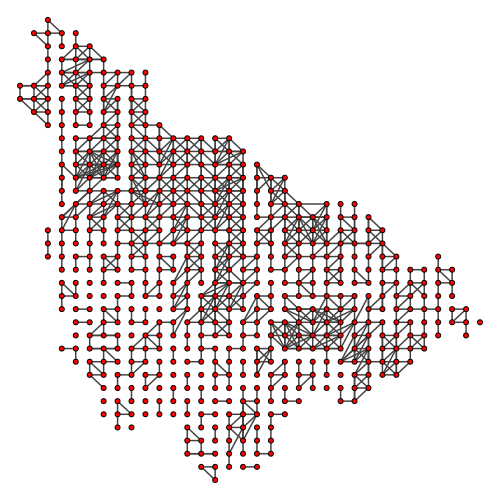

In [22]:
# Rede cujo limiar foi estabelecido para obter o mesmo número de arestas observado na rede GT-Network (Pearson)
g_graph_1270[0]

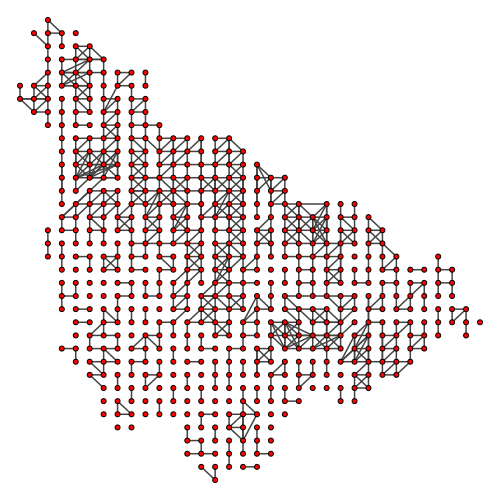

In [23]:
# Rede cujo limiar foi estabelecido de acordo com a relação entre o valor de MI e o diâmetro da rede
g_graph_max_diameter[0]

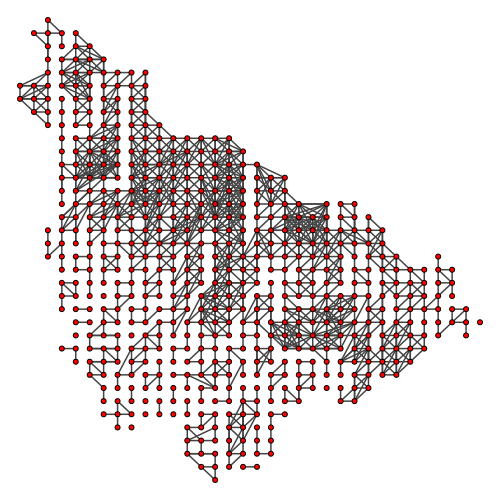

In [24]:
# Rede cujo limiar foi estabelecido através de 1% das maiores correlações
g_graph_highest_corr[0]

---
### Backbone para cada rede

In [25]:
i = time.time()
# Edges: 1270 
backbone_1270 = backbone(g_graph_full[1],0.1272)

# Edges: 964
backbone_max_diameter = backbone(g_graph_full[1],0.1124)

# Edges: 1720
backbone_highest_corr = backbone(g_graph_full[1],0.14254)
e = time.time()
print(e-i,'s')

3.520333766937256 s


---
### Redes Backbone


In [26]:
# Desired number of edges: 1270 
g_graph_backbone_1270 = g_graph(backbone_1270)

# Desired number of edges: 964
g_graph_backbone_max_diameter = g_graph(backbone_max_diameter)

# Desired number of edges: 1720
g_graph_backbone_highest_corr = g_graph(backbone_highest_corr)

In [27]:
print("g_graph_backbone_1270 - Weights: {:.2f} - {:.2f}".format(min(g_graph_backbone_1270[1].es['weight']),max(g_graph_backbone_1270[1].es['weight'])))
print("g_graph_backbone_max_diameter - Weights: {:.2f} - {:.2f}".format(min(g_graph_backbone_max_diameter[1].es['weight']),max(g_graph_backbone_max_diameter[1].es['weight'])))
print("g_graph_backbone_highest_corr - Weights: {:.2f} - {:.2f}".format(min(g_graph_backbone_highest_corr[1].es['weight']),max(g_graph_backbone_highest_corr[1].es['weight'])))

g_graph_backbone_1270 - Weights: 0.18 - 0.66
g_graph_backbone_max_diameter - Weights: 0.18 - 0.69
g_graph_backbone_highest_corr - Weights: 0.16 - 0.63


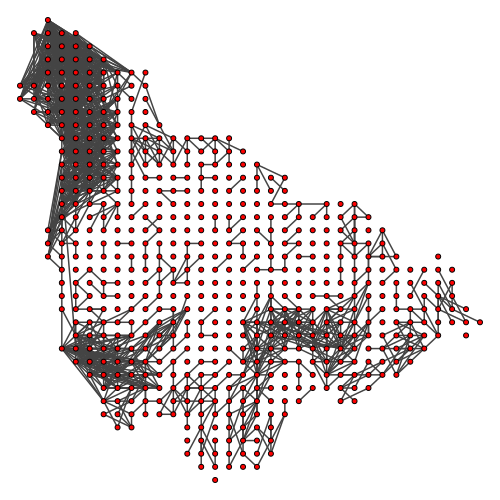

In [28]:
g_graph_backbone_1270[0]

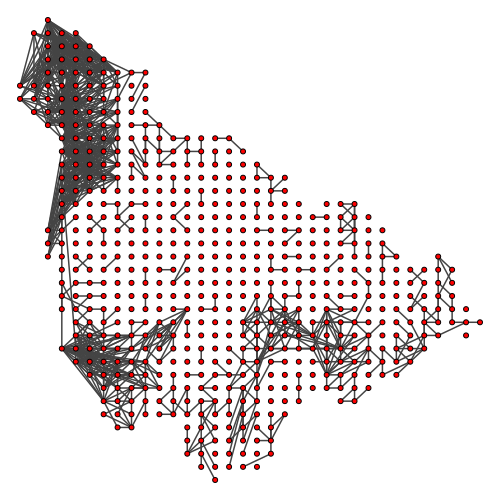

In [29]:
g_graph_backbone_max_diameter[0]

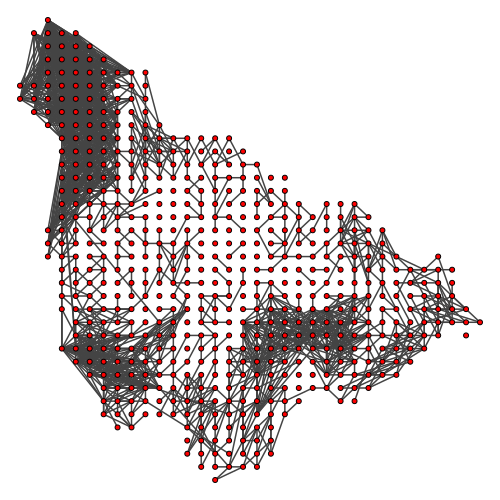

In [30]:
g_graph_backbone_highest_corr[0]

---
### Metrics
>Número de componentes, Média dos componentes, Número de singletons, Tamanho do maior componente, Average shortest path, Clustering coefficient, Diâmetro, Parâmetro de heterogeneidade para as distribuições de grau

In [31]:
g_gt_pearson = igraph.Graph.Read_GraphML('gt-bb-weather-radar-watershed/GT.GraphML')

g_bb_pearson = igraph.Graph.Read_GraphML('gt-bb-weather-radar-watershed/BB.GraphML')

In [32]:
# Global threshold based networks

# 1270 edges
metrics_graph_1270 = metrics(g_graph_1270[1]).all_metrics()

# threshold defined by the maximum diameter
metrics_graph_max_diameter = metrics(g_graph_max_diameter[1]).all_metrics()

# threshold defined by the highest correlation (1%)
metrics_graph_highest_corr = metrics(g_graph_highest_corr[1]).all_metrics()

# GT pearson
metrics_graph_gt_pearson = metrics(g_gt_pearson).all_metrics()

# Backbone based networks

# Number of edges: 1270 
metrics_graph_backbone_1270 = metrics(g_graph_backbone_1270[1]).all_metrics()

# Number of edges: 964
metrics_graph_backbone_max_diameter = metrics(g_graph_backbone_max_diameter[1]).all_metrics()

# Number of edges: 1720
metrics_graph_backbone_highest_corr = metrics(g_graph_backbone_highest_corr[1]).all_metrics()

# BB pearson
metrics_graph_backbone_pearson = metrics(g_bb_pearson).all_metrics()


In [33]:
def shared_edges(g1,g2):
    edges1 = g1.get_edgelist()
    edges2 = g2.get_edgelist()
    shared_edges = []
    if g1.ecount() >= g2.ecount():
        for e in edges1:
            if e in edges2:
                shared_edges.append(e)
    else:
        for e in g2.get_edgelist():
            if e in edges1:
                shared_edges.append(e)
                
    # It calculates the percentage considering the total number of edges for the two graphs distinctly 
    """
        p = {
            'Perct for g1': (len(shared_edges)/len(edges1))*100,
            'Perct for g2': (len(shared_edges)/len(edges2))*100
        }    
    """
    p = {
        'Perct for g1': str(len(shared_edges))+' of '+str(len(edges1)),
        'Perct for g2': str(len(shared_edges))+' of '+str(len(edges2))
    } 
    return(shared_edges,p)

In [34]:
# Attributes 

g_graph_1270[1]['heterogeneity_parameter'] = metrics_graph_1270[0] # heterogeneity parameter
g_graph_1270[1]['number_of_components'] = metrics_graph_1270[1]['n_comp'] # number of components
g_graph_1270[1]['number_of_singletons'] = metrics_graph_1270[1]['n_singletons'] # number of singletons
g_graph_1270[1]['biggest_component'] = metrics_graph_1270[1]['biggest_comp'] # biggest component
g_graph_1270[1]['avg_component_size'] = metrics_graph_1270[1]['avg_comp'] # avg component size
g_graph_1270[1]['avg_shortest_path'] = metrics_graph_1270[2] # avg shortest path

g_graph_max_diameter[1]['heterogeneity_parameter'] = metrics_graph_max_diameter[0] # heterogeneity parameter
g_graph_max_diameter[1]['number_of_components'] = metrics_graph_max_diameter[1]['n_comp'] # number of components
g_graph_max_diameter[1]['number_of_singletons'] = metrics_graph_max_diameter[1]['n_singletons'] # number of singletons
g_graph_max_diameter[1]['biggest_component'] = metrics_graph_max_diameter[1]['biggest_comp'] # biggest component
g_graph_max_diameter[1]['avg_component_size'] = metrics_graph_max_diameter[1]['avg_comp'] # avg component size
g_graph_max_diameter[1]['avg_shortest_path'] = metrics_graph_max_diameter[2] # avg shortest path

g_graph_highest_corr[1]['heterogeneity_parameter'] = metrics_graph_highest_corr[0] # heterogeneity parameter
g_graph_highest_corr[1]['number_of_components'] = metrics_graph_highest_corr[1]['n_comp'] # number of components
g_graph_highest_corr[1]['number_of_singletons'] = metrics_graph_highest_corr[1]['n_singletons'] # number of singletons
g_graph_highest_corr[1]['biggest_component'] = metrics_graph_highest_corr[1]['biggest_comp'] # biggest component
g_graph_highest_corr[1]['avg_component_size'] = metrics_graph_highest_corr[1]['avg_comp'] # avg component size
g_graph_highest_corr[1]['avg_shortest_path'] = metrics_graph_highest_corr[2] # avg shortest path

g_graph_backbone_1270[1]['heterogeneity_parameter'] = metrics_graph_backbone_1270[0] # heterogeneity parameter
g_graph_backbone_1270[1]['number_of_components'] = metrics_graph_backbone_1270[1]['n_comp'] # number of components
g_graph_backbone_1270[1]['number_of_singletons'] = metrics_graph_backbone_1270[1]['n_singletons'] # number of singletons
g_graph_backbone_1270[1]['biggest_component'] = metrics_graph_backbone_1270[1]['biggest_comp'] # biggest component
g_graph_backbone_1270[1]['avg_component_size'] = metrics_graph_backbone_1270[1]['avg_comp'] # avg component size
g_graph_backbone_1270[1]['avg_shortest_path'] = metrics_graph_backbone_1270[2] # avg shortest path

g_graph_backbone_max_diameter[1]['heterogeneity_parameter'] = metrics_graph_backbone_max_diameter[0] # heterogeneity parameter
g_graph_backbone_max_diameter[1]['number_of_components'] = metrics_graph_backbone_max_diameter[1]['n_comp'] # number of components
g_graph_backbone_max_diameter[1]['number_of_singletons'] = metrics_graph_backbone_max_diameter[1]['n_singletons'] # number of singletons
g_graph_backbone_max_diameter[1]['biggest_component'] = metrics_graph_backbone_max_diameter[1]['biggest_comp'] # biggest component
g_graph_backbone_max_diameter[1]['avg_component_size'] = metrics_graph_backbone_max_diameter[1]['avg_comp'] # avg component size
g_graph_backbone_max_diameter[1]['avg_shortest_path'] = metrics_graph_backbone_max_diameter[2] # avg shortest path

g_graph_backbone_highest_corr[1]['heterogeneity_parameter'] = metrics_graph_backbone_highest_corr[0] # heterogeneity parameter
g_graph_backbone_highest_corr[1]['number_of_components'] = metrics_graph_backbone_highest_corr[1]['n_comp'] # number of components
g_graph_backbone_highest_corr[1]['number_of_singletons'] = metrics_graph_backbone_highest_corr[1]['n_singletons'] # number of singletons
g_graph_backbone_highest_corr[1]['biggest_component'] = metrics_graph_backbone_highest_corr[1]['biggest_comp'] # biggest component
g_graph_backbone_highest_corr[1]['avg_component_size'] = metrics_graph_backbone_highest_corr[1]['avg_comp'] # avg component size
g_graph_backbone_highest_corr[1]['avg_shortest_path'] = metrics_graph_backbone_highest_corr[2] # avg shortest path

In [35]:
metrics_gt_df = pd.DataFrame([metrics_graph_1270[0],metrics_graph_1270[1]['n_comp'],metrics_graph_1270[1]['n_singletons'],metrics_graph_1270[1]['biggest_comp'],metrics_graph_1270[1]['avg_comp'],metrics_graph_1270[2],metrics_graph_1270[3],metrics_graph_1270[4]],index=['Heterogeneity Parameter','Number of components','Number of singletons','Biggest component','Average component','Avearge shortest path','Clustering coefficient','Diameter'],columns=['Global threshold for 1270 edges (MI)'])
metrics_gt_df['Global threshold for maximum diameter (MI)'] = [metrics_graph_max_diameter[0],metrics_graph_max_diameter[1]['n_comp'],metrics_graph_max_diameter[1]['n_singletons'],metrics_graph_max_diameter[1]['biggest_comp'],metrics_graph_max_diameter[1]['avg_comp'],metrics_graph_max_diameter[2],metrics_graph_max_diameter[3],metrics_graph_max_diameter[4]]
metrics_gt_df['Global threshold for the highest correlations (MI)'] = [metrics_graph_highest_corr[0],metrics_graph_highest_corr[1]['n_comp'],metrics_graph_highest_corr[1]['n_singletons'],metrics_graph_highest_corr[1]['biggest_comp'],metrics_graph_highest_corr[1]['avg_comp'],metrics_graph_highest_corr[2],metrics_graph_highest_corr[3],metrics_graph_highest_corr[4]]
metrics_gt_df['Global threshold for Pearson correlation'] = [metrics_graph_gt_pearson[0],metrics_graph_gt_pearson[1]['n_comp'],metrics_graph_gt_pearson[1]['n_singletons'],metrics_graph_gt_pearson[1]['biggest_comp'],metrics_graph_gt_pearson[1]['avg_comp'],metrics_graph_gt_pearson[2],metrics_graph_gt_pearson[3],metrics_graph_gt_pearson[4]]

In [36]:
metrics_gt_df

Global threshold for 1270 edges (MI)  \
Heterogeneity Parameter                              1.386432   
Number of components                                49.000000   
Number of singletons                                18.000000   
Biggest component                                  430.000000   
Average component                                   11.979592   
Avearge shortest path                               11.811405   
Clustering coefficient                               0.500394   
Diameter                                            40.000000   

                         Global threshold for maximum diameter (MI)  \
Heterogeneity Parameter                                    1.422816   
Number of components                                      82.000000   
Number of singletons                                      33.000000   
Biggest component                                        305.000000   
Average component                                          7.158537   
Avearge shortest path                                     10.381185   
Clustering coefficient                                     0.474442   
Diameter                                                  49.000000   

                         Global threshold for the highest correlations (MI)  \
Heterogeneity Parameter                                           1.382081    
Number of components                                             27.000000    
Number of singletons                                              9.000000    
Biggest component                                               479.000000    
Average component                                                21.740741    
Avearge shortest path                                            10.129646    
Clustering coefficient                                            0.536811    
Diameter                                                         38.000000    

                         Global threshold for Pearson correlation  
Heterogeneity Parameter                                  1.775303  
Number of components                                   125.000000  
Number of singletons                                    85.000000  
Biggest component                                      349.000000  
Average component                                        4.696000  
Avearge shortest path                                    8.935197  
Clustering coefficient                                   0.536295  
Diameter                                                37.000000

In [37]:
metrics_bb_df = pd.DataFrame([metrics_graph_backbone_1270[0],metrics_graph_backbone_1270[1]['n_comp'],metrics_graph_backbone_1270[1]['n_singletons'],metrics_graph_backbone_1270[1]['biggest_comp'],metrics_graph_backbone_1270[1]['avg_comp'],metrics_graph_backbone_1270[2],metrics_graph_backbone_1270[3],metrics_graph_backbone_1270[4]],index=['Heterogeneity Parameter','Number of components','Number of singletons','Biggest component','Average component','Avearge shortest path','Clustering coefficient','Diameter'],columns=['Backbone for 1270 edges (MI)'])
metrics_bb_df['Backbone for maximum diameter (MI)'] = [metrics_graph_backbone_max_diameter[0],metrics_graph_backbone_max_diameter[1]['n_comp'],metrics_graph_backbone_max_diameter[1]['n_singletons'],metrics_graph_backbone_max_diameter[1]['biggest_comp'],metrics_graph_backbone_max_diameter[1]['avg_comp'],metrics_graph_backbone_max_diameter[2],metrics_graph_backbone_max_diameter[3],metrics_graph_backbone_max_diameter[4]]
metrics_bb_df['Backbone for the highest correlations (MI)'] = [metrics_graph_backbone_highest_corr[0],metrics_graph_backbone_highest_corr[1]['n_comp'],metrics_graph_backbone_highest_corr[1]['n_singletons'],metrics_graph_backbone_highest_corr[1]['biggest_comp'],metrics_graph_backbone_highest_corr[1]['avg_comp'],metrics_graph_backbone_highest_corr[2],metrics_graph_backbone_highest_corr[3],metrics_graph_backbone_highest_corr[4]]
metrics_bb_df['Backbone for Pearson correlation'] = [metrics_graph_backbone_pearson[0],metrics_graph_backbone_pearson[1]['n_comp'],metrics_graph_backbone_pearson[1]['n_singletons'],metrics_graph_backbone_pearson[1]['biggest_comp'],metrics_graph_backbone_pearson[1]['avg_comp'],metrics_graph_backbone_pearson[2],metrics_graph_backbone_pearson[3],metrics_graph_backbone_pearson[4]]

In [38]:
metrics_bb_df

Backbone for 1270 edges (MI)  \
Heterogeneity Parameter                      2.572515   
Number of components                       124.000000   
Number of singletons                        96.000000   
Biggest component                          381.000000   
Average component                            4.733871   
Avearge shortest path                        9.771663   
Clustering coefficient                       0.163441   
Diameter                                    41.000000   

                         Backbone for maximum diameter (MI)  \
Heterogeneity Parameter                            2.962490   
Number of components                             202.000000   
Number of singletons                             152.000000   
Biggest component                                152.000000   
Average component                                  2.905941   
Avearge shortest path                              3.880094   
Clustering coefficient                             0.161835   
Diameter                                          19.000000   

                         Backbone for the highest correlations (MI)  \
Heterogeneity Parameter                                    2.138550   
Number of components                                      52.000000   
Number of singletons                                      42.000000   
Biggest component                                        520.000000   
Average component                                         11.288462   
Avearge shortest path                                      8.452780   
Clustering coefficient                                     0.171204   
Diameter                                                  34.000000   

                         Backbone for Pearson correlation  
Heterogeneity Parameter                          3.262465  
Number of components                           237.000000  
Number of singletons                           218.000000  
Biggest component                              161.000000  
Average component                                2.476793  
Avearge shortest path                            4.422860  
Clustering coefficient                           0.295445  
Diameter                                        19.000000

#### Shared edges 

> Confusion matrix with the number of shared edges 

> Percentage of shared edges calculated for both graphs (the ones that are being tested)

In [39]:
# MI and Pearson considering GT approach:
# g_graph_1270[1]
# g_graph_highest_corr[1]
# g_graph_max_diameter[1]
# g_gt_pearson
competitors_gt = [g_graph_1270[1],g_graph_highest_corr[1],g_graph_max_diameter[1],g_gt_pearson]

g_graph_1270_vs_all = {}
g_graph_highest_corr_vs_all = {}
g_graph_max_diameter_vs_all = {}
g_gt_pearson_vs_all = {}

for i in range(4):
    g_graph_1270_vs_all[0,i] = (shared_edges(competitors_gt[0],competitors_gt[i]))
    g_graph_highest_corr_vs_all[1,i] = (shared_edges(competitors_gt[1],competitors_gt[i]))
    g_graph_max_diameter_vs_all[2,i] = (shared_edges(competitors_gt[2],competitors_gt[i]))
    g_gt_pearson_vs_all[3,i] = (shared_edges(competitors_gt[3],competitors_gt[i]))
    

# MI and Pearson considering Backbone approach
# g_graph_backbone_1270[1]
# g_graph_backbone_highest_corr[1]
# g_graph_backbone_max_diameter[1]
# g_bb_pearson

competitors_bb = [g_graph_backbone_1270[1],g_graph_backbone_highest_corr[1],g_graph_backbone_max_diameter[1],g_bb_pearson]

g_graph_bb_1270_vs_all = {}
g_graph_bb_highest_corr_vs_all = {}
g_graph_bb_max_diameter_vs_all = {}
g_bb_pearson_vs_all = {}

for i in range(4):
    g_graph_bb_1270_vs_all[0,i] = (shared_edges(competitors_bb[0],competitors_bb[i]))
    g_graph_bb_highest_corr_vs_all[1,i] = (shared_edges(competitors_bb[1],competitors_bb[i]))
    g_graph_bb_max_diameter_vs_all[2,i] = (shared_edges(competitors_bb[2],competitors_bb[i]))
    g_bb_pearson_vs_all[3,i] = (shared_edges(competitors_bb[3],competitors_bb[i]))

---
#### Global threshold approach

In [40]:
mi_pearson_gt = pd.DataFrame([len(g_graph_1270_vs_all[0,0][0]),len(g_graph_1270_vs_all[0,1][0]),len(g_graph_1270_vs_all[0,2][0]),len(g_graph_1270_vs_all[0,3][0])],index=['1270 edges (MI)','1% highest correlation (MI)','Maximum diameter (MI)','Pearson'],columns=['1270 edges (MI)'])
mi_pearson_gt['1% highest correlation (MI)'] = [len(g_graph_highest_corr_vs_all[1,0][0]),len(g_graph_highest_corr_vs_all[1,1][0]),len(g_graph_highest_corr_vs_all[1,2][0]),len(g_graph_highest_corr_vs_all[1,3][0])]
mi_pearson_gt['Maximum diameter (MI)'] = [len(g_graph_max_diameter_vs_all[2,0][0]),len(g_graph_max_diameter_vs_all[2,1][0]),len(g_graph_max_diameter_vs_all[2,2][0]),len(g_graph_max_diameter_vs_all[2,3][0])]
mi_pearson_gt['Pearson'] = [len(g_gt_pearson_vs_all[3,0][0]),len(g_gt_pearson_vs_all[3,1][0]),len(g_gt_pearson_vs_all[3,2][0]),len(g_gt_pearson_vs_all[3,3][0])]

In [41]:
mi_pearson_gt

1270 edges (MI)  1% highest correlation (MI)  \
1270 edges (MI)                         1270                         1270   
1% highest correlation (MI)             1270                         1720   
Maximum diameter (MI)                    964                          964   
Pearson                                  966                         1195   

                             Maximum diameter (MI)  Pearson  
1270 edges (MI)                                964      966  
1% highest correlation (MI)                    964     1195  
Maximum diameter (MI)                          964      765  
Pearson                                        765     1270

In [42]:
mi_1270_pearson_gt_perct = pd.DataFrame([g_graph_1270_vs_all[0,0][1]['Perct for g1'],g_graph_1270_vs_all[0,1][1]['Perct for g1'],g_graph_1270_vs_all[0,2][1]['Perct for g1'],g_graph_1270_vs_all[0,3][1]['Perct for g1']],index=['1270 edges (MI) vs. 1270 edges (MI)','1270 edges (MI) vs. 1% highest correlation (MI)','1270 edges (MI) vs. Maximum diameter (MI)','1270 edges (MI) vs. 1270 edges (Pearson)'],columns=['% for G1'])
mi_1270_pearson_gt_perct['% for G2'] = [g_graph_1270_vs_all[0,0][1]['Perct for g2'],g_graph_1270_vs_all[0,1][1]['Perct for g2'],g_graph_1270_vs_all[0,2][1]['Perct for g2'],g_graph_1270_vs_all[0,3][1]['Perct for g2']]

In [43]:
mi_highest_corr_pearson_gt_perct = pd.DataFrame([g_graph_highest_corr_vs_all[1,0][1]['Perct for g1'],g_graph_highest_corr_vs_all[1,1][1]['Perct for g1'],g_graph_highest_corr_vs_all[1,2][1]['Perct for g1'],g_graph_highest_corr_vs_all[1,3][1]['Perct for g1']],index=['1% highest correlation (MI) vs. 1270 edges (MI)','1% highest correlation (MI) vs. 1% highest correlation (MI)','1% highest correlation (MI) vs. Maximum diameter (MI)','1% highest correlation (MI) vs. 1270 edges (Pearson)'],columns=['% for G1'])
mi_highest_corr_pearson_gt_perct['% for G2'] = [g_graph_highest_corr_vs_all[1,0][1]['Perct for g2'],g_graph_highest_corr_vs_all[1,1][1]['Perct for g2'],g_graph_highest_corr_vs_all[1,2][1]['Perct for g2'],g_graph_highest_corr_vs_all[1,3][1]['Perct for g2']]

In [44]:
mi_max_diameter_pearson_gt_perct = pd.DataFrame([g_graph_max_diameter_vs_all[2,0][1]['Perct for g1'],g_graph_max_diameter_vs_all[2,1][1]['Perct for g1'],g_graph_max_diameter_vs_all[2,2][1]['Perct for g1'],g_graph_max_diameter_vs_all[2,3][1]['Perct for g1']],index=['Maximum diameter (MI) vs. 1270 edges (MI)','Maximum diameter (MI) vs. 1% highest correlation (MI)','Maximum diameter (MI) vs. Maximum diameter (MI)','Maximum diameter (MI) vs. 1270 edges (Pearson)'],columns=['% for G1'])
mi_max_diameter_pearson_gt_perct['% for G2'] = [g_graph_max_diameter_vs_all[2,0][1]['Perct for g2'],g_graph_max_diameter_vs_all[2,1][1]['Perct for g2'],g_graph_max_diameter_vs_all[2,2][1]['Perct for g2'],g_graph_max_diameter_vs_all[2,3][1]['Perct for g2']]

In [45]:
pearson_gt_perct = pd.DataFrame([g_gt_pearson_vs_all[3,0][1]['Perct for g1'],g_gt_pearson_vs_all[3,1][1]['Perct for g1'],g_gt_pearson_vs_all[3,2][1]['Perct for g1'],g_gt_pearson_vs_all[3,3][1]['Perct for g1']],index=['1270 edges (Pearson) vs. 1270 edges (MI)','1270 edges (Pearson) vs. 1% highest correlation (MI)','1270 edges (Pearson) vs. Maximum diameter (MI)','1270 edges (Pearson) vs. 1270 edges (Pearson)'],columns=['% for G1'])
pearson_gt_perct['% for G2'] = [g_gt_pearson_vs_all[3,0][1]['Perct for g2'],g_gt_pearson_vs_all[3,1][1]['Perct for g2'],g_gt_pearson_vs_all[3,2][1]['Perct for g2'],g_gt_pearson_vs_all[3,3][1]['Perct for g2']]

In [46]:
dfs = [mi_1270_pearson_gt_perct, mi_highest_corr_pearson_gt_perct, mi_max_diameter_pearson_gt_perct, pearson_gt_perct]
comparisons_gt = pd.concat(dfs)

In [47]:
comparisons_gt

% for G1      % for G2
1270 edges (MI) vs. 1270 edges (MI)                 1270 of 1270  1270 of 1270
1270 edges (MI) vs. 1% highest correlation (MI)     1270 of 1270  1270 of 1720
1270 edges (MI) vs. Maximum diameter (MI)            964 of 1270    964 of 964
1270 edges (MI) vs. 1270 edges (Pearson)             966 of 1270   966 of 1270
1% highest correlation (MI) vs. 1270 edges (MI)     1270 of 1720  1270 of 1270
1% highest correlation (MI) vs. 1% highest corr...  1720 of 1720  1720 of 1720
1% highest correlation (MI) vs. Maximum diamete...   964 of 1720    964 of 964
1% highest correlation (MI) vs. 1270 edges (Pea...  1195 of 1720  1195 of 1270
Maximum diameter (MI) vs. 1270 edges (MI)             964 of 964   964 of 1270
Maximum diameter (MI) vs. 1% highest correlatio...    964 of 964   964 of 1720
Maximum diameter (MI) vs. Maximum diameter (MI)       964 of 964    964 of 964
Maximum diameter (MI) vs. 1270 edges (Pearson)        765 of 964   765 of 1270
1270 edges (Pearson) vs. 1270 edges (MI)             966 of 1270   966 of 1270
1270 edges (Pearson) vs. 1% highest correlation...  1195 of 1270  1195 of 1720
1270 edges (Pearson) vs. Maximum diameter (MI)       765 of 1270    765 of 964
1270 edges (Pearson) vs. 1270 edges (Pearson)       1270 of 1270  1270 of 1270

---
#### Backbone approach

In [48]:
mi_pearson_bb = pd.DataFrame([len(g_graph_bb_1270_vs_all[0,0][0]),len(g_graph_bb_1270_vs_all[0,1][0]),len(g_graph_bb_1270_vs_all[0,2][0]),len(g_graph_bb_1270_vs_all[0,3][0])],index=['1270 edges BB (MI)','1% highest correlation BB (MI)','Maximum diameter BB (MI)','Pearson BB'],columns=['1270 edges BB (MI)'])
mi_pearson_bb['1% highest correlation BB (MI)'] = [len(g_graph_bb_highest_corr_vs_all[1,0][0]),len(g_graph_bb_highest_corr_vs_all[1,1][0]),len(g_graph_bb_highest_corr_vs_all[1,2][0]),len(g_graph_bb_highest_corr_vs_all[1,3][0])]
mi_pearson_bb['Maximum diameter BB (MI)'] = [len(g_graph_bb_max_diameter_vs_all[2,0][0]),len(g_graph_bb_max_diameter_vs_all[2,1][0]),len(g_graph_bb_max_diameter_vs_all[2,2][0]),len(g_graph_bb_max_diameter_vs_all[2,3][0])]
mi_pearson_bb['Pearson BB'] = [len(g_bb_pearson_vs_all[3,0][0]),len(g_bb_pearson_vs_all[3,1][0]),len(g_bb_pearson_vs_all[3,2][0]),len(g_bb_pearson_vs_all[3,3][0])]

In [49]:
mi_pearson_bb

1270 edges BB (MI)  \
1270 edges BB (MI)                            1270   
1% highest correlation BB (MI)                 818   
Maximum diameter BB (MI)                       647   
Pearson BB                                     697   

                                1% highest correlation BB (MI)  \
1270 edges BB (MI)                                         818   
1% highest correlation BB (MI)                            1720   
Maximum diameter BB (MI)                                   475   
Pearson BB                                                 631   

                                Maximum diameter BB (MI)  Pearson BB  
1270 edges BB (MI)                                   647         697  
1% highest correlation BB (MI)                       475         631  
Maximum diameter BB (MI)                             964         678  
Pearson BB                                           678        1275

In [50]:
mi_1270_pearson_bb_perct = pd.DataFrame([g_graph_bb_1270_vs_all[0,0][1]['Perct for g1'],g_graph_bb_1270_vs_all[0,1][1]['Perct for g1'],g_graph_bb_1270_vs_all[0,2][1]['Perct for g1'],g_graph_bb_1270_vs_all[0,3][1]['Perct for g1']],index=['1270 edges BB (MI) vs. 1270 edges BB (MI)','1270 edges BB (MI) vs. 1% highest correlation BB (MI)','1270 edges BB (MI) vs. Maximum diameter BB (MI)','1270 edges BB (MI) vs. 1270 edges BB (Pearson)'],columns=['% for G1'])
mi_1270_pearson_bb_perct['% for G2'] = [g_graph_bb_1270_vs_all[0,0][1]['Perct for g2'],g_graph_bb_1270_vs_all[0,1][1]['Perct for g2'],g_graph_bb_1270_vs_all[0,2][1]['Perct for g2'],g_graph_bb_1270_vs_all[0,3][1]['Perct for g2']]

In [51]:
mi_highest_corr_pearson_bb_perct = pd.DataFrame([g_graph_bb_highest_corr_vs_all[1,0][1]['Perct for g1'],g_graph_bb_highest_corr_vs_all[1,1][1]['Perct for g1'],g_graph_bb_highest_corr_vs_all[1,2][1]['Perct for g1'],g_graph_bb_highest_corr_vs_all[1,3][1]['Perct for g1']],index=['1% highest correlation BB (MI) vs. 1270 edges BB (MI)','1% highest correlation BB (MI) vs. 1% highest correlation BB (MI)','1% highest correlation BB (MI) vs. Maximum diameter BB (MI)','1% highest correlation BB (MI) vs. 1270 edges BB (Pearson)'],columns=['% for G1'])
mi_highest_corr_pearson_bb_perct['% for G2'] = [g_graph_bb_highest_corr_vs_all[1,0][1]['Perct for g2'],g_graph_bb_highest_corr_vs_all[1,1][1]['Perct for g2'],g_graph_bb_highest_corr_vs_all[1,2][1]['Perct for g2'],g_graph_bb_highest_corr_vs_all[1,3][1]['Perct for g2']]

In [52]:
mi_max_diameter_pearson_bb_perct = pd.DataFrame([g_graph_bb_max_diameter_vs_all[2,0][1]['Perct for g1'],g_graph_bb_max_diameter_vs_all[2,1][1]['Perct for g1'],g_graph_bb_max_diameter_vs_all[2,2][1]['Perct for g1'],g_graph_bb_max_diameter_vs_all[2,3][1]['Perct for g1']],index=['Maximum diameter BB (MI) vs. 1270 edges BB (MI)','Maximum diameter BB (MI) vs. 1% highest correlation BB (MI)','Maximum diameter BB (MI) vs. Maximum diameter BB (MI)','Maximum diameter BB (MI) vs. 1270 edges BB (Pearson)'],columns=['% for G1'])
mi_max_diameter_pearson_bb_perct['% for G2'] = [g_graph_bb_max_diameter_vs_all[2,0][1]['Perct for g2'],g_graph_bb_max_diameter_vs_all[2,1][1]['Perct for g2'],g_graph_bb_max_diameter_vs_all[2,2][1]['Perct for g2'],g_graph_bb_max_diameter_vs_all[2,3][1]['Perct for g2']]

In [53]:
pearson_bb_perct = pd.DataFrame([g_bb_pearson_vs_all[3,0][1]['Perct for g1'],g_bb_pearson_vs_all[3,1][1]['Perct for g1'],g_bb_pearson_vs_all[3,2][1]['Perct for g1'],g_bb_pearson_vs_all[3,3][1]['Perct for g1']],index=['1270 edges BB (Pearson) vs. 1270 edges BB (MI)','1270 edges BB (Pearson) vs. 1% highest correlation BB (MI)','1270 edges BB (Pearson) vs. Maximum diameter BB (MI)','1270 edges BB (Pearson) vs. 1270 edges BB (Pearson)'],columns=['% for G1'])
pearson_bb_perct['% for G2'] = [g_bb_pearson_vs_all[3,0][1]['Perct for g2'],g_bb_pearson_vs_all[3,1][1]['Perct for g2'],g_bb_pearson_vs_all[3,2][1]['Perct for g2'],g_bb_pearson_vs_all[3,3][1]['Perct for g2']]

In [54]:
dfs_bb = [mi_1270_pearson_bb_perct, mi_highest_corr_pearson_bb_perct, mi_max_diameter_pearson_bb_perct, pearson_bb_perct]
comparisons_bb = pd.concat(dfs_bb)

In [55]:
comparisons_bb

% for G1      % for G2
1270 edges BB (MI) vs. 1270 edges BB (MI)           1270 of 1270  1270 of 1270
1270 edges BB (MI) vs. 1% highest correlation B...   818 of 1270   818 of 1720
1270 edges BB (MI) vs. Maximum diameter BB (MI)      647 of 1270    647 of 964
1270 edges BB (MI) vs. 1270 edges BB (Pearson)       697 of 1270   697 of 1275
1% highest correlation BB (MI) vs. 1270 edges B...   818 of 1720   818 of 1270
1% highest correlation BB (MI) vs. 1% highest c...  1720 of 1720  1720 of 1720
1% highest correlation BB (MI) vs. Maximum diam...   475 of 1720    475 of 964
1% highest correlation BB (MI) vs. 1270 edges B...   631 of 1720   631 of 1275
Maximum diameter BB (MI) vs. 1270 edges BB (MI)       647 of 964   647 of 1270
Maximum diameter BB (MI) vs. 1% highest correla...    475 of 964   475 of 1720
Maximum diameter BB (MI) vs. Maximum diameter B...    964 of 964    964 of 964
Maximum diameter BB (MI) vs. 1270 edges BB (Pea...    678 of 964   678 of 1275
1270 edges BB (Pearson) vs. 1270 edges BB (MI)       697 of 1275   697 of 1270
1270 edges BB (Pearson) vs. 1% highest correlat...   631 of 1275   631 of 1720
1270 edges BB (Pearson) vs. Maximum diameter BB...   678 of 1275    678 of 964
1270 edges BB (Pearson) vs. 1270 edges BB (Pear...  1275 of 1275  1275 of 1275

#### Relation between geographic distance and topological distance

In [56]:
# Execution time: 38s
i = time.time()
# GT-based networks

shortest_paths_gt_1270 = shortest_paths(g_graph_1270[1],weight=False)
shortest_paths_gt_max_diameter = shortest_paths(g_graph_max_diameter[1],weight=False)
shortest_paths_gt_highest_correlation = shortest_paths(g_graph_highest_corr[1],weight=False)

e = time.time()
print(e-i,'s')

40.586565256118774 s


In [61]:
shortest_paths_gt_1270_geo_top = {}
shortest_paths_gt_max_diameter_geo_top = {}
shortest_paths_gt_highest_correlation_geo_top = {}
shortest_paths_bb_1270_geo_top = {}
shortest_paths_bb_max_diameter_geo_top = {}
shortest_paths_bb_highest_correlation_geo_top = {}

for i in shortest_paths_gt_1270:
    shortest_paths_gt_1270_geo_top[i] = [shortest_paths_gt_1270[i],geo_dist[i]]
    
for i in shortest_paths_gt_max_diameter:
    shortest_paths_gt_max_diameter_geo_top[i] = [shortest_paths_gt_max_diameter[i],geo_dist[i]]
    
for i in shortest_paths_gt_highest_correlation:
    shortest_paths_gt_highest_correlation_geo_top[i] = [shortest_paths_gt_highest_correlation[i],geo_dist[i]]

"""
for i in shortest_paths_bb_1270:
    shortest_paths_bb_1270_geo_top[i] = [shortest_paths_bb_1270[i],geo_dist[i]]
    
for i in shortest_paths_bb_max_diameter:
    shortest_paths_bb_max_diameter_geo_top[i] = [shortest_paths_bb_max_diameter[i],geo_dist[i]]
    
for i in shortest_paths_bb_highest_correlation:
    shortest_paths_bb_highest_correlation_geo_top[i] = [shortest_paths_bb_highest_correlation[i],geo_dist[i]]
"""

'\nfor i in shortest_paths_bb_1270:\n    shortest_paths_bb_1270_geo_top[i] = [shortest_paths_bb_1270[i],geo_dist[i]]\n    \nfor i in shortest_paths_bb_max_diameter:\n    shortest_paths_bb_max_diameter_geo_top[i] = [shortest_paths_bb_max_diameter[i],geo_dist[i]]\n    \nfor i in shortest_paths_bb_highest_correlation:\n    shortest_paths_bb_highest_correlation_geo_top[i] = [shortest_paths_bb_highest_correlation[i],geo_dist[i]]\n'

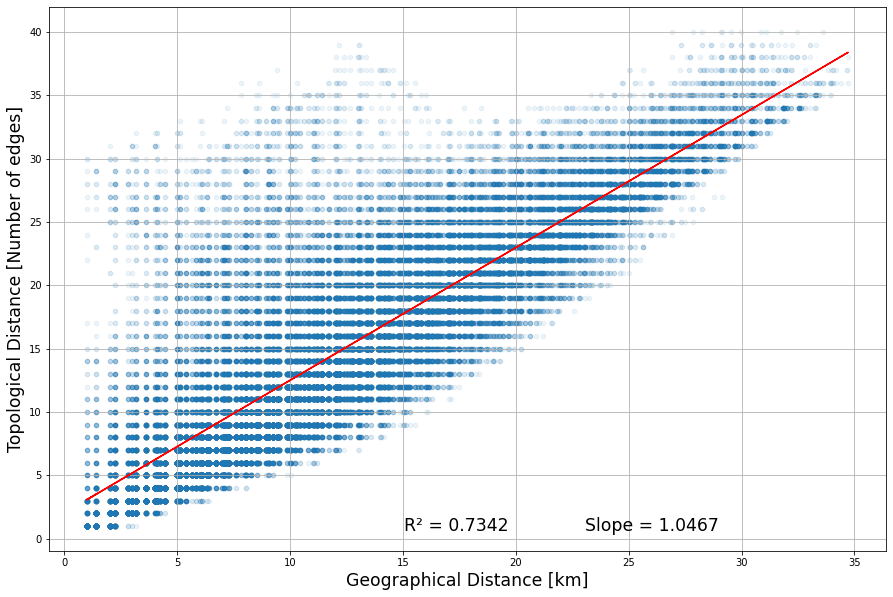

In [62]:
plot_geo_top(shortest_paths_gt_1270_geo_top)

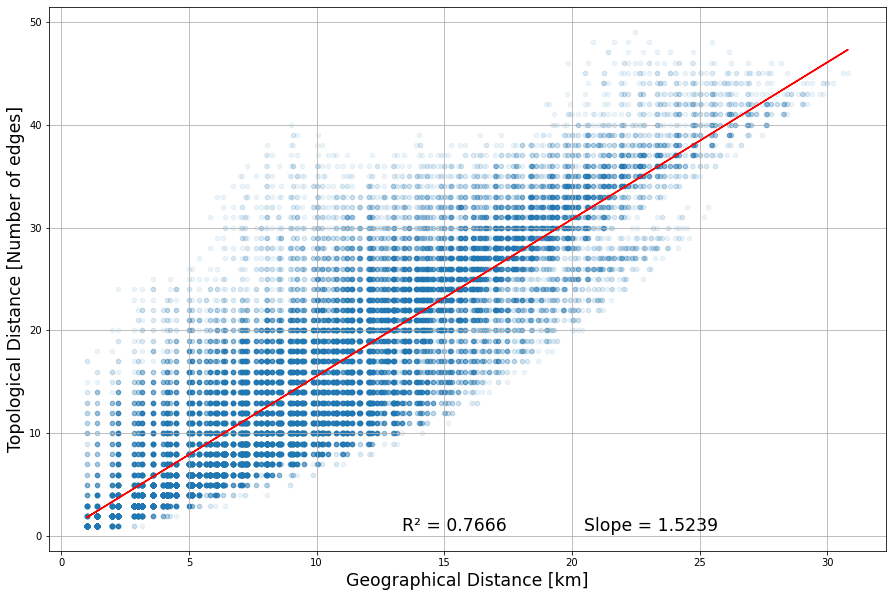

In [63]:
plot_geo_top(shortest_paths_gt_max_diameter_geo_top)

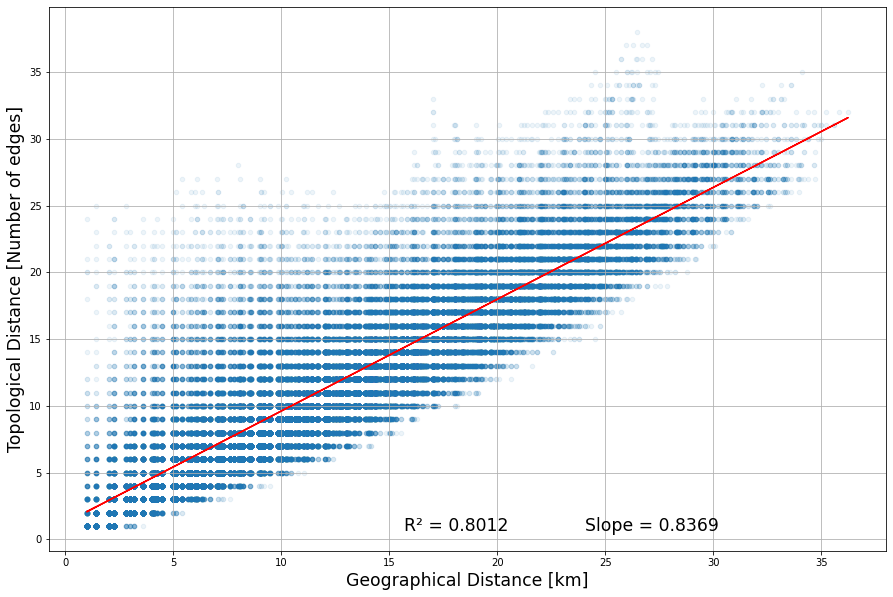

In [64]:
plot_geo_top(shortest_paths_gt_highest_correlation_geo_top)

### Shapefile

In [147]:
def avg_shortest_path(graph):
    avg_shortest_paths = {}
    shrtst_paths_inf = graph.shortest_paths()
    sp = [];
    for nodes in range(len(shrtst_paths_inf)):
        v = [];
        for paths in range(len(shrtst_paths_inf[nodes])):
            if ((shrtst_paths_inf[nodes][paths] != float('inf')) and (shrtst_paths_inf[nodes][paths] != 0) and (nodes != paths)):
                v.append(shrtst_paths_inf[nodes][paths]);
        if (len(v) == 0):
            avg = 0;
        else:
            avg = sum(v)/len(v);
        sp.append(avg);

    for i in range(587):
        avg_shortest_paths[i] = sp[i]
    
    return(avg_shortest_paths)

In [148]:
g_graph_1270_avg_shortest_path_per_node = avg_shortest_path(g_graph_1270[1])
g_graph_max_diameter_avg_shortest_path_per_node = avg_shortest_path(g_graph_max_diameter[1])
g_graph_highest_corr_avg_shortest_path_per_node = avg_shortest_path(g_graph_highest_corr[1])

g_graph_backbone_1270_avg_shortest_path_per_node = avg_shortest_path(g_graph_backbone_1270[1])
g_graph_backbone_max_diameter_avg_shortest_path_per_node = avg_shortest_path(g_graph_backbone_max_diameter[1])
g_graph_backbone_highest_corr_avg_shortest_path_per_node = avg_shortest_path(g_graph_backbone_highest_corr[1])

---

In [149]:
g_gt_pearson.vs.attributes()

['label',
 'x',
 'y',
 'weightedDegree',
 'degree',
 'clusterCoeficient',
 'closeness',
 'betweenness',
 'shortestPathMean',
 'strength',
 'id']

In [150]:
x = g_gt_pearson.vs['x']
y = g_gt_pearson.vs['y']

In [151]:
# Other attributes
g_graph_1270[1].vs['lat'] = y
g_graph_1270[1].vs['lon'] = x
g_graph_1270[1].vs['label'] = [i for i in range(g_graph_1270[1].vcount())]
g_graph_1270[1].vs['degree'] = g_graph_1270[1].degree()
g_graph_1270[1].vs['betweenness'] = g_graph_1270[1].betweenness()
g_graph_1270[1].vs['closeness'] = g_graph_1270[1].closeness()
g_graph_1270[1].vs['strength'] = g_graph_1270[1].strength(weights=g_graph_1270[1].es['weight'])
g_graph_1270[1].vs['shortestPathMean'] = list(g_graph_1270_avg_shortest_path_per_node.values())
g_graph_1270[1].vs['clusterCoefficient'] = g_graph_1270[1].transitivity_local_undirected()

g_graph_max_diameter[1].vs['lat'] = y
g_graph_max_diameter[1].vs['lon'] = x
g_graph_max_diameter[1].vs['label'] = [i for i in range(g_graph_max_diameter[1].vcount())]
g_graph_max_diameter[1].vs['degree'] = g_graph_max_diameter[1].degree()
g_graph_max_diameter[1].vs['betweenness'] = g_graph_max_diameter[1].betweenness()
g_graph_max_diameter[1].vs['closeness'] = g_graph_max_diameter[1].closeness()
g_graph_max_diameter[1].vs['strength'] = g_graph_max_diameter[1].strength(weights=g_graph_max_diameter[1].es['weight'])
g_graph_max_diameter[1].vs['shortestPathMean'] = list(g_graph_max_diameter_avg_shortest_path_per_node.values())
g_graph_max_diameter[1].vs['clusterCoefficient'] = g_graph_max_diameter[1].transitivity_local_undirected()

g_graph_highest_corr[1].vs['lat'] = y
g_graph_highest_corr[1].vs['lon'] = x
g_graph_highest_corr[1].vs['label'] = [i for i in range(g_graph_highest_corr[1].vcount())]
g_graph_highest_corr[1].vs['degree'] = g_graph_highest_corr[1].degree()
g_graph_highest_corr[1].vs['betweenness'] = g_graph_highest_corr[1].betweenness()
g_graph_highest_corr[1].vs['closeness'] = g_graph_highest_corr[1].closeness()
g_graph_highest_corr[1].vs['strength'] = g_graph_highest_corr[1].strength(weights=g_graph_highest_corr[1].es['weight'])
g_graph_highest_corr[1].vs['shortestPathMean'] = list(g_graph_highest_corr_avg_shortest_path_per_node.values())
g_graph_highest_corr[1].vs['clusterCoefficient'] = g_graph_highest_corr[1].transitivity_local_undirected()

# Backbone

g_graph_backbone_1270[1].vs['lat'] = y
g_graph_backbone_1270[1].vs['lon'] = x
g_graph_backbone_1270[1].vs['label'] = [i for i in range(g_graph_backbone_1270[1].vcount())]
g_graph_backbone_1270[1].vs['degree'] = g_graph_backbone_1270[1].degree()
g_graph_backbone_1270[1].vs['betweenness'] = g_graph_backbone_1270[1].betweenness()
g_graph_backbone_1270[1].vs['closeness'] = g_graph_backbone_1270[1].closeness()
g_graph_backbone_1270[1].vs['strength'] = g_graph_backbone_1270[1].strength(weights=g_graph_backbone_1270[1].es['weight'])
g_graph_backbone_1270[1].vs['shortestPathMean'] = list(g_graph_backbone_1270_avg_shortest_path_per_node.values())
g_graph_backbone_1270[1].vs['clusterCoefficient'] = g_graph_backbone_1270[1].transitivity_local_undirected()

g_graph_backbone_max_diameter[1].vs['lat'] = y
g_graph_backbone_max_diameter[1].vs['lon'] = x
g_graph_backbone_max_diameter[1].vs['label'] = [i for i in range(g_graph_backbone_max_diameter[1].vcount())]
g_graph_backbone_max_diameter[1].vs['degree'] = g_graph_backbone_max_diameter[1].degree()
g_graph_backbone_max_diameter[1].vs['betweenness'] = g_graph_backbone_max_diameter[1].betweenness()
g_graph_backbone_max_diameter[1].vs['closeness'] = g_graph_backbone_max_diameter[1].closeness()
g_graph_backbone_max_diameter[1].vs['strength'] = g_graph_backbone_max_diameter[1].strength(weights=g_graph_backbone_max_diameter[1].es['weight'])
g_graph_backbone_max_diameter[1].vs['shortestPathMean'] = list(g_graph_1270_avg_shortest_path_per_node.values())
g_graph_backbone_max_diameter[1].vs['clusterCoefficient'] = g_graph_backbone_max_diameter[1].transitivity_local_undirected()

g_graph_backbone_highest_corr[1].vs['lat'] = y
g_graph_backbone_highest_corr[1].vs['lon'] = x
g_graph_backbone_highest_corr[1].vs['label'] = [i for i in range(g_graph_1270[1].vcount())]
g_graph_backbone_highest_corr[1].vs['degree'] = g_graph_1270[1].degree()
g_graph_backbone_highest_corr[1].vs['betweenness'] = g_graph_1270[1].betweenness()
g_graph_backbone_highest_corr[1].vs['closeness'] = g_graph_1270[1].closeness()
g_graph_backbone_highest_corr[1].vs['strength'] = g_graph_1270[1].strength(weights=g_graph_1270[1].es['weight'])
g_graph_backbone_highest_corr[1].vs['shortestPathMean'] = list(g_graph_1270_avg_shortest_path_per_node.values())
g_graph_backbone_highest_corr[1].vs['clusterCoefficient'] = g_graph_1270[1].transitivity_local_undirected()

In [50]:
# Resolução PPi São Roque
dx = 0.00747135
dy = -0.00675451

shp = Shapefile(g_graph_1270[1], 'g_graph_1270_MI_shape')
shp.create_shape(' /g_graph_1270_shape_MI', dx, dy)

shp1 = Shapefile(g_graph_max_diameter[1], 'g_graph_max_diameter_MI_shape')
shp1.create_shape(' /g_graph_max_diameter_shape_MI', dx, dy)

shp2 = Shapefile(g_graph_highest_corr[1], 'g_graph_highest_corr_MI_shape')
shp2.create_shape(' /g_graph_highest_corr_shape_MI', dx, dy)

# Backbone

shp3 = Shapefile(g_graph_backbone_1270[1], 'g_graph_1270_MI_backbone_shape')
shp3.create_shape(' /g_graph_1270_shape_MI_backbone', dx, dy)

shp4 = Shapefile(g_graph_backbone_max_diameter[1], 'g_graph_max_diameter_MI_backbone_shape')
shp4.create_shape(' /g_graph_max_diameter_shape_MI_backbone', dx, dy)

shp5 = Shapefile(g_graph_backbone_highest_corr[1], 'g_graph_highest_corr_MI_backbone_shape')
shp5.create_shape(' /g_graph_highest_corr_shape_MI_backbone', dx, dy)

---
### GraphML

In [156]:
g_graph_1270[1].write_graphml('g_graph_1270_MI.GraphML')
g_graph_max_diameter[1].write_graphml('g_graph_max_diameter_MI.GraphML')
g_graph_highest_corr[1].write_graphml('g_graph_highest_corr_MI.GraphML')

g_graph_backbone_1270[1].write_graphml('g_graph_backbone_1270_MI.GraphML')
g_graph_backbone_max_diameter[1].write_graphml('g_graph_backbone_max_diameter_MI.GraphML')
g_graph_backbone_highest_corr[1].write_graphml('g_graph_backbone_highest_corr_MI.GraphML')

---
#### 3D projection

<IPython.core.display.Javascript object>


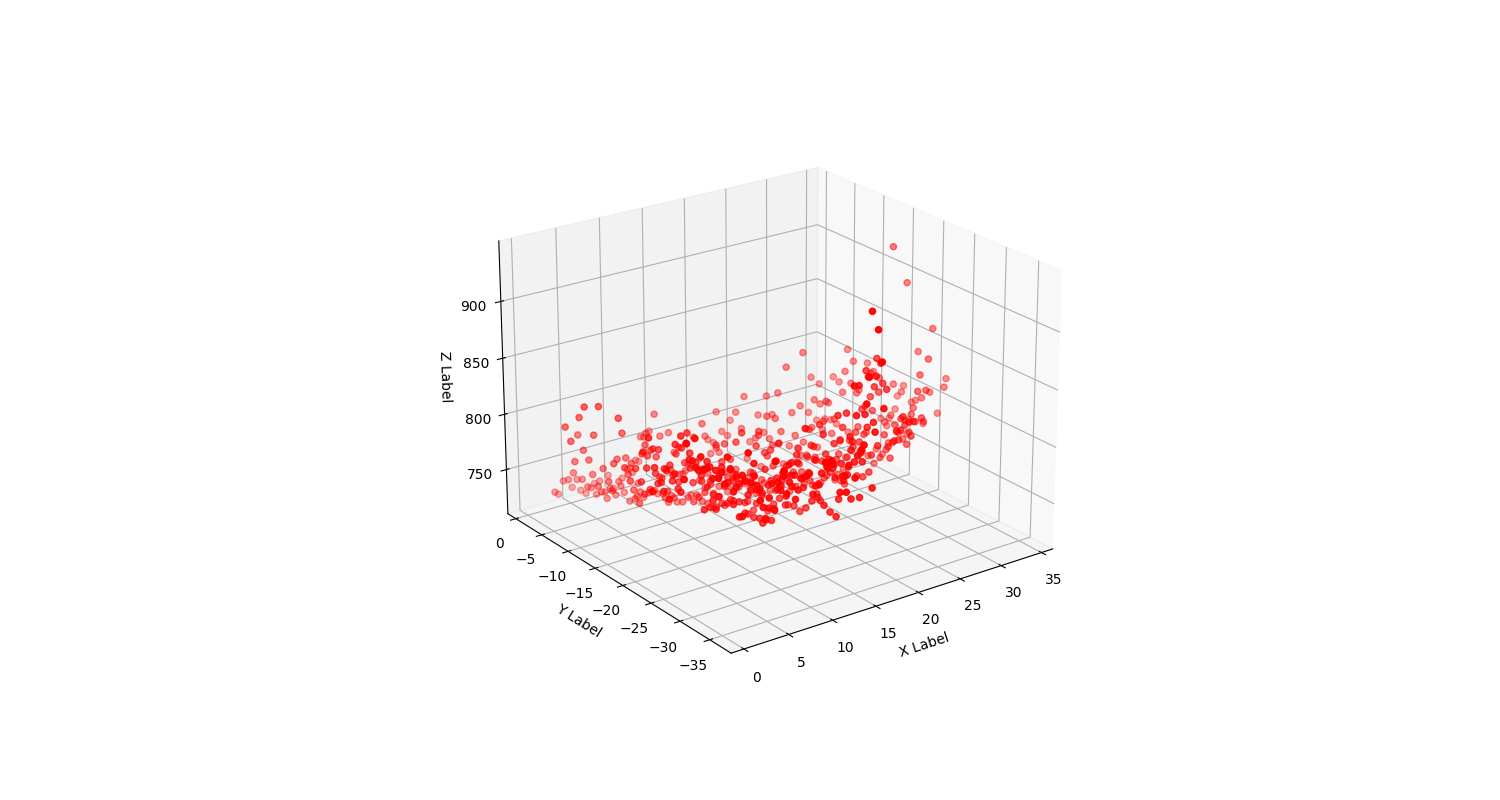

In [84]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')

ys = [-i[0] for i in position]
xs = [i[1] for i in position]
zs = alt

ax.scatter(xs, ys, zs, marker='o',c='r')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

for i in range(0, 360, 30):
    ax.view_init(None, i)
    plt.show()
